In [4]:
import sys
sys.path.insert(0,'../caffe/python')

import caffe
import numpy as np
from matplotlib import pylab as pl
import os
import cv2
import time
import anno_func, json
%matplotlib inline

In [5]:
datadir = "../../data/"

filedir = datadir + "/annotations.json"
ids = open(datadir + "/test/ids.txt").read().splitlines()

ids = ['10056']
print ids

annos = json.loads(open(filedir).read())

['10056']


In [4]:
netname = "fast_r_cnn"
model_file = '../../cvpr_fastrcnn/vgg_cnn_m_1024/test.prototxt'
model_weights = "../../cvpr_fastrcnn/vgg_cnn_m_1024/vgg_cnn_m_1024_fast_rcnn_iter_40000.caffemodel"
gid = 0

def get_net():
    global gid
    if gid != -1:
        caffe.set_mode_gpu()
        caffe.set_device(gid)
        print "Using GPU id", gid
    else:
        caffe.set_mode_cpu()
        print "Using CPU"
    net = caffe.Net(model_file, 
                 model_weights, caffe.TEST)
    return net

net = get_net()

Using GPU id 0


RuntimeError: Could not open file ../../cvpr_fastrcnn/vgg_cnn_m_1024/test.prototxt

In [5]:
netname = "my_tt100k_iter_40000"
model_file = '../model/model.prototxt'
#model_weights = "../model/model.caffemodel"
model_weights = "../model/snapshots/TT100K_iter_40000.caffemodel"
gid = 0

def get_net():
    global gid
    if gid != -1:
        caffe.set_mode_gpu()
        caffe.set_device(gid)
        print "Using GPU id", gid
    else:
        caffe.set_mode_cpu()
        print "Using CPU"
    net = caffe.Net(model_file, 
                 model_weights, caffe.TEST)
    return net

net = get_net()

Using GPU id 0


In [3]:
netname = "TT100K_baselr_change_iter_40000"
model_file = '../model/model.prototxt'
#model_weights = "../model/model.caffemodel"
model_weights = "../model/snapshots/TT100K_baselr_change_iter_40000.caffemodel"
gid = 0

def get_net():
    global gid
    if gid != -1:
        caffe.set_mode_gpu()
        caffe.set_device(gid)
        print "Using GPU id", gid
    else:
        caffe.set_mode_cpu()
        print "Using CPU"
    net = caffe.Net(model_file, 
                 model_weights, caffe.TEST)
    return net

net = get_net()

Using GPU id 0


In [10]:
netname = "TT100K_TRAIN_01_Iter_40000_T1"
model_file = '../model/model.prototxt'
model_weights = "../model/snapshots/TT100K_TRAIN_01_iter_40000.caffemodel"
gid = 0

def get_net():
    global gid
    if gid != -1:
        caffe.set_mode_gpu()
        caffe.set_device(gid)
        print "Using GPU id", gid
    else:
        caffe.set_mode_cpu()
        print "Using CPU"
    net = caffe.Net(model_file, 
                 model_weights, caffe.TEST)
    return net

net = get_net()

Using GPU id 0


In [11]:
mean = caffe.proto.caffe_pb2.BlobProto.FromString(open("../../data/lmdb/test_mean.binaryproto").read())
mn = np.array(mean.data)

print mn.shape
print mean.channels, mean.height, mean.width

mn = mn.reshape(mean.channels, mean.height, mean.width)
mn = mn.transpose((1,2,0))

print mn.shape

(12582912,)
3 2048 2048
(2048, 2048, 3)


0.0
1.0


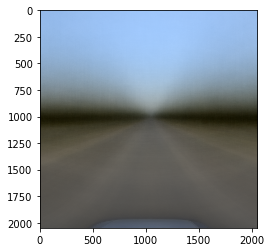

In [12]:
pmn = mn.copy()
pmn = (pmn-pmn.min())/(pmn.max() - pmn.min())

print pmn.min()
print pmn.max()
#print pmn-pmn.min()

#pl.figure(figsize=(20,20))
pl.imshow(pmn[:,:,[2,1,0]])

(2048, 2048, 3)
(2048, 2048, 3)


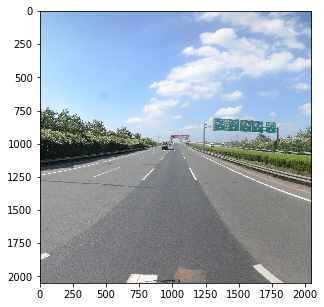

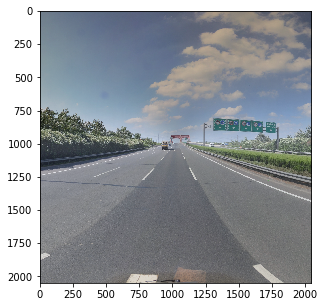

In [13]:
import random
imgid = "29998"

imgdata = anno_func.load_img(annos, datadir, imgid)

print imgdata.shape
print imgdata[:,:,[0,1,2]].shape

# original image
pl.figure(figsize=(5,5))
pl.imshow(imgdata)

imgdata = imgdata[:,:,[2,1,0]]*255. - mn

#pl.hist(imgdata.flat)
#pl.show()
rimgdata = (imgdata-imgdata.min())/(imgdata.max()-imgdata.min())

# subtracted image = original image - mean image
pl.figure(figsize=(5,5))
pl.imshow(rimgdata[:,:,[2,1,0]])

In [14]:

def draw_rects(image, rects, color=(1,0,0), width=2):
    if len(rects) == 0: return image
    for i in range(rects.shape[0]):
        xmin, ymin, w, h = rects[i, :].astype(np.int)
        xmax = xmin + w
        ymax = ymin + h
        image[ymin:ymax+1, xmin:xmin+width, :] = color
        image[ymin:ymax+1, xmax:xmax+width, :] = color
        image[ymin:ymin+width, xmin:xmax+1, :] = color
        image[ymax:ymax+width, xmin:xmax+1, :] = color 
    return image

def fix_box(bb, mask, xsize, ysize, res):
    bb = np.copy(bb)
    
    y_offset = np.array([np.arange(0, ysize, res)]).T
    y_offset = np.tile(y_offset, (1, int(xsize/res)))
    x_offset = np.arange(0, xsize, res)
    x_offset = np.tile(x_offset, (int(ysize/res), 1))
    bb[0, :, :] += x_offset
    bb[2, :, :] += x_offset
    bb[1, :, :] += y_offset
    bb[3, :, :] += y_offset
    
    mask = np.array([mask]*4)
    sb = bb[mask].reshape((4,-1))
    
    rects = sb.T

    rects = rects[np.logical_and((rects[:, 2] - rects[:, 0]) > 0, (rects[:, 3] - rects[:, 1]) > 0), :]
    rects[:, (2, 3)] -= rects[:, (0, 1)]
    
    return rects

def work(imgdata, all_rect):
    data_layer = net.blobs['data']
    for resize in [0.5,1,2,4]:
        prob_th = 0.95
        gbox = 0.1
        if resize < 1:
            resize = data_layer.shape[2]*1.0/imgdata.shape[0]
            data = cv2.resize(imgdata, (data_layer.shape[2], data_layer.shape[3]))
        else:
            data = cv2.resize(imgdata, (imgdata.shape[0]*resize, imgdata.shape[1]*resize))
        data = data.transpose(2,0,1)
        #print data.shape
        #data_layer.reshape(*((1,)+data.shape))
        netsize = 1024
        overlap_size = 256

        res1 = 4
        res2 = 16
        pixel_whole = np.zeros((1,data.shape[1]/res1,data.shape[2]/res1))
        bbox_whole = np.zeros((4,data.shape[1]/res1,data.shape[2]/res1))
        type_whole = np.zeros((1,data.shape[1]/res2,data.shape[2]/res2))

        tmp = 0
        for x in range((data.shape[1]-1)/netsize+1):
            xl = min(x*netsize, data.shape[1]-netsize-overlap_size)
            xr = xl+netsize+overlap_size
            xsl = xl if xl==0 else xl+overlap_size/2
            xsr = xr if xr==data.shape[1] else xr-overlap_size/2
            xtl = xsl - xl
            xtr = xsr - xl
            for y in range((data.shape[2]-1)/netsize+1):
                yl = min(y*netsize, data.shape[2]-netsize-overlap_size)
                yr = yl+netsize+overlap_size
                ysl = yl if yl==0 else yl+overlap_size/2
                ysr = yr if yr==data.shape[2] else yr-overlap_size/2
                ytl = ysl - yl
                ytr = ysr - yl
                #print xl,xr,yl,yr,xsl,xsr,ysl,ysr,xtl,xtr,ytl,ytr
                fdata = data[:,xl:xr,yl:yr]


                data_layer.data[...] = fdata
                net.forward()
                pixel = net.blobs['output_pixel'].data[0]
                pixel = np.exp(pixel) / (np.exp(pixel[0]) + np.exp(pixel[1]))
                bbox = net.blobs['output_bb'].data[0]
                mtypes = net.blobs['output_type'].data[0]
                mtypes = np.argmax(mtypes, axis=0)
                #print pixel.shape, bbox.shape, mtypes.shape, pixel[1,xtl/res1:xtr/res1, ytl/res1:ytr/res1].shape

                pixel_whole[:,xsl/res1:xsr/res1,ysl/res1:ysr/res1] = pixel[1,xtl/res1:xtr/res1, ytl/res1:ytr/res1]
                bbox_whole[:,xsl/res1:xsr/res1,ysl/res1:ysr/res1] = bbox[:,xtl/res1:xtr/res1, ytl/res1:ytr/res1]
                type_whole[:,xsl/res2:xsr/res2,ysl/res2:ysr/res2] = mtypes[xtl/res2:xtr/res2, ytl/res2:ytr/res2]
                if resize<1: break
            if resize<1: break

        #pl.imshow(pixel_whole[0])
        #pl.show()
        #pl.imshow(type_whole[0])
        #pl.show()

        rects = fix_box(bbox_whole, pixel_whole[0]>prob_th, imgdata.shape[0]*resize, imgdata.shape[1]*resize, res1)
        merge_rects, scores = cv2.groupRectangles(rects.tolist(), 2, gbox)
        merge_rects = np.array(merge_rects, np.float32) / resize
        #imgdraw = rimgdata.copy()
        #draw_rects(imgdraw, merge_rects)

        #pl.figure(figsize=(20,20))
        #pl.imshow(imgdraw)
        mrect = merge_rects * resize / res2 
        if len(mrect)>0:
            mrect[:,[2,3]]+=mrect[:,[0,1]]

        for i,rect in enumerate(mrect):
            xl = np.floor(rect[0])
            yl = np.floor(rect[1])
            xr = np.ceil(rect[2])+1
            yr = np.ceil(rect[3])+1
            xl = np.clip(xl, 0, type_whole.shape[1])
            yl = np.clip(yl, 0, type_whole.shape[2])
            xr = np.clip(xr, 0, type_whole.shape[1])
            yr = np.clip(yr, 0, type_whole.shape[2])

            tp = type_whole[0,int(yl):int(yr),int(xl):int(xr)]
            uni, num = np.unique(tp, return_counts=True)
            maxtp, maxc = 0,0
            for tid, c in zip(uni, num):
                if tid != 0 and maxc<c:
                    maxtp, maxc = tid, c
            if maxtp != 0:
                all_rect.append((int(maxtp), merge_rects[i].tolist(), float(scores[i]), resize))
                #print maxtp, maxc, annos['types'][int(maxtp-1)]

import time

rectmap = {}
display_time = 10

for i, imgid in enumerate(ids):
    imgdata = anno_func.load_img(annos, datadir, imgid)
    imgdata = imgdata[:,:,[2,1,0]]*255. - mn

    now_time = time.time()
    all_rect = []
    
    print '\r', "begin", imgid, "---", i, 
    #sys.stdout.flush()
    work(imgdata, all_rect)
    rectmap[imgid] = all_rect
    #print "worker time elapsed:", time.time()-now_time, 
    #sys.stdout.flush()
    
    if i%display_time==0:
        now_time = time.time()
        result_annos = anno_func.get_refine_rects(annos, rectmap)
        #sm = anno_func.eval_annos(annos, result_annos, 0.5, types=anno_func.type45)
        #print "evaluate time elapsed:", time.time()-now_time
        #sys.stdout.flush()
        open("../results/%s_result_annos.json"%netname, "w").write(json.dumps(result_annos))
        #open("../results/%s_result.json"%netname, "w").write(json.dumps(sm))
            
    #if i>=300: break

begin 10056 --- 0
